Проверяем выделение признаков из модели `PricePredictionLandingRequest`

In [1]:
import pandas as pd
import numpy as np

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
from google.protobuf.json_format import MessageToDict

In [5]:
import sys
sys.path.append('../../price_estimator/price-estimator-rest-api/')
sys.path.append('../../price_estimator/price-estimator-rest-api/proto')
sys.path.append('../../price_estimator/price-estimator-rest-api/api')

In [6]:
from proto.realty.offer import common_pb2
from proto.realty import model_pb2
from proto.realty.prediction import price_prediction_pb2
from proto.realty.offer.unified_offer_parts import address_part_pb2, offer_category_part_pb2, object_infos_part_pb2

In [7]:
from common import snake_dict
from data_processing import _get_quadkeys, StatContainer
from models import ModelContainer, PricePredictor

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
round_to_1000 = PricePredictor.round_to_1000

# CONTAINERS

## Stats

In [9]:
stat_container = StatContainer()

[# INFO     [2021-03-26 15:26:36,534]  load_stat (building_id | plain)
[# INFO     [2021-03-26 15:26:42,048]  load_stat (city_quadkey | plain)
[# INFO     [2021-03-26 15:26:42,720]  load_stat (region_quadkey | plain)
[# INFO     [2021-03-26 15:26:42,820]  load_stat (unified_address | custom)
[# INFO     [2021-03-26 15:26:43,754]  load_stat (city_quadkey | custom)
[# INFO     [2021-03-26 15:26:45,236]  load_stat (region_quadkey | custom)


## Model

In [10]:
model_path = ("/Users/naidenov-alex/Documents/GitHub/vertis-ml/"
"realty/price_estimator/price-estimator-rest-api/"
"model/regular/sell_apartment_landing_2021_03_26.cbm")

In [11]:
model = ModelContainer(model_path)

[# INFO     [2021-03-26 15:26:45,340]  load_model (/Users/naidenov-alex/Documents/GitHub/vertis-ml/realty/price_estimator/price-estimator-rest-api/model/regular/sell_apartment_landing_2021_03_26.cbm)


# DATA

## Target

In [12]:
# результаты модели без floor_total на валидационной выборке с 2021-01-01 
# https://nirvana.yandex-team.ru/flow/575ec9d9-f77b-4966-a68a-5c4dbb854404/615855d2-5e99-4997-a1a4-9ed6672a2b7c/graph/FlowchartEndpoint/53c4d482-d598-4b8c-9dc4-54b86942756d
    
val_set = pd.read_csv("/Users/naidenov-alex/work/data/val_set_landing_2020_03_26.tsv", sep="\t", names=["target", "prediction", "offer_id"], skiprows=1)

val_set["target"] = np.exp(val_set["target"]).round().astype(int)
val_set["prediction"] = np.exp(val_set["prediction"])#.round().astype(int)

## Features

In [13]:
# данные для обучения с floor_total из базы домов с 2021-01-01 
# https://nirvana.yandex-team.ru/flow/575ec9d9-f77b-4966-a68a-5c4dbb854404/5484800b-9354-4a7a-98f1-7d9c0ccfa220/graph/FlowchartEndpoint/0d914950-c8c1-4f49-a86f-b1ad51945788

raw_data = pd.read_csv("/Users/naidenov-alex/work/data/sell_apartment_landing_sampling.tsv", sep="\t")

In [21]:
all_data = pd.merge(val_set, raw_data, how="inner", on="offer_id")

In [22]:
def make_message(row):
    row = row.to_dict()
    message = price_prediction_pb2.PricePredictionLandingRequest()

    message.apartment.apartment_area = row["area"]
    message.apartment.rooms_total = row["rooms_offered"]
    # message.apartment.highrise_apartment_info.floors.append(data_nirvana["floor"])
    message.apartment.general_apartment_info.ceiling_height.value = row['ceiling_height']
    message.apartment.building_info.built_year.value = row['build_year']
    message.apartment.building_info.flats_count.value = row['flats_count']
    message.apartment.building_info.expect_demolition.value = bool(row['expect_demolition'])
    message.apartment.building_info.has_lift.value = bool(row['has_elevator'])
    message.apartment.building_info.building_id.value = int(row['building_id'])
    message.apartment.building_info.building_series.id = row['building_series_id']
    message.apartment.building_info.building_type = row['building_type']
    message.apartment.building_info.floors_total.value = row['floors_total']

    message.location.unified_coordinates.latitude = row['lat']
    message.location.unified_coordinates.longitude = row['lon']


    c = address_part_pb2.Address.Component()
    c.region_type = model_pb2.RegionType.Value('CITY')
    c.value = row['locality_name']
    message.location.unified_address.component.append(c)
    message.location.unified_address.unified_oneline = row["unified_address"]

    message.location.subject_federation_geoid = row["subject_federation_id"]
    return message

In [23]:
def _add_default_factors(price_prediction_request: dict) -> dict:
    if 'apartment' not in price_prediction_request:
        price_prediction_request['apartment'] = MessageToDict(
            offer_category_part_pb2.ApartmentCategory(),
            including_default_value_fields=True
        )
    if 'highrise_apartment_info' not in price_prediction_request['apartment']:
        price_prediction_request['apartment']['highrise_apartment_info'] = MessageToDict(
            object_infos_part_pb2.HighRiseApartmentInfo(),
            including_default_value_fields=True
        )
    if 'general_apartment_info' not in price_prediction_request['apartment']:
        price_prediction_request['apartment']['general_apartment_info'] = MessageToDict(
            object_infos_part_pb2.GeneralApartmentInfo(),
            including_default_value_fields=True
        )
    if 'building_info' not in price_prediction_request['apartment']:
        price_prediction_request['apartment']['building_info'] = MessageToDict(
            object_infos_part_pb2.BuildingInfo(),
            including_default_value_fields=True
        )
    if 'building_series' not in price_prediction_request['apartment']['building_info']:
        price_prediction_request['apartment']['building_info']['building_series'] = MessageToDict(
            object_infos_part_pb2.BuildingSeries(),
            including_default_value_fields=True
        )
    if 'location' not in price_prediction_request:
        price_prediction_request['location'] = MessageToDict(
            address_part_pb2.LocationUnified(),
            including_default_value_fields=True
        )
    if 'unified_coordinates' not in price_prediction_request['location']:
        price_prediction_request['location']['unified_coordinates'] = MessageToDict(
            model_pb2.GeoPoint(),
            including_default_value_fields=True
        )
    if 'geocoder_address' not in price_prediction_request['location']:
        price_prediction_request['location']['geocoder_address'] = MessageToDict(
            address_part_pb2.Address(),
            including_default_value_fields=True
        )
    
    return price_prediction_request

def parse_message(message):
    
    price_prediction_request = snake_dict(
        MessageToDict(message)
    )
    factors = dict()

    price_prediction_request = _add_default_factors(price_prediction_request)

    apartment = price_prediction_request['apartment']

    factors['area'] = apartment.get("apartment_area", 0)
    factors['rooms_offered'] = apartment.get("rooms_total", 0)
    # factors['floor'] = (apartment["highrise_apartment_info"].get("floors", []) + [0])[0]
    factors['ceiling_height'] = apartment["general_apartment_info"].get("ceiling_height", 0)

    building_info = apartment["building_info"]
    factors['build_year'] = building_info.get("built_year", 0)
    factors['flats_count'] = building_info.get("flats_count", 0)
    # factors['floors_total'] = building_info.get("floors_total", 0)
    factors['expect_demolition'] = building_info.get("expect_demolition", False)
    factors['has_elevator'] = building_info.get('has_lift', False)
    factors['building_id'] = building_info.get('building_id', 0)
    factors['building_series_id'] = building_info["building_series"].get('id', 0)
    if 'building_type' in building_info:
        factors['building_type'] = common_pb2.BuildingType.Value(building_info['building_type'])
    else:
        factors['building_type'] = 0

    location = price_prediction_request['location']
    factors['lat'] = location['unified_coordinates'].get('latitude', 0)
    factors['lon'] = location['unified_coordinates'].get('longitude', 0)
    # city_quadkey, region_quadkey
    (factors['city_quadkey'], factors['region_quadkey']) = _get_quadkeys(factors['lat'], factors['lon'])

    address = location['unified_address']
    factors['locality_name'] = (["Город"] + [
        c["value"] for c in address['component']
    #     if c["region_type"] == model_pb2.RegionType.Value('CITY')
        if c["regionType"] == 'CITY'
    ])[-1]
    factors['unified_address'] = address.get("unified_oneline", "")

    factors["subject_federation_id"] = location.get('subject_federation_geoid', 225)
    
    return factors

In [24]:
def get_prediction(row):
    return model.predict(
        stat_container.enrich_factors(
            parse_message(
                make_message(row)
            ), model_type="landing"
        )
    )

In [47]:
data = all_data#[:1000].copy()

In [48]:
data["proto_prediction_raw"] = data.progress_apply(get_prediction, axis=1)

100%|██████████| 180777/180777 [06:00<00:00, 501.56it/s]


In [49]:
data["proto_prediction"] = data["proto_prediction_raw"].progress_apply(round_to_1000)

100%|██████████| 180777/180777 [00:00<00:00, 824212.75it/s]


In [50]:
data.iloc[
    ((data["prediction"] - data["proto_prediction_raw"]) / data["prediction"]).abs().idxmax()
]

target                                             365597504
prediction                                   63409072.592653
offer_id                                 7568656758537956250
first_day_exposition                        1614546000000000
area                                                   316.0
                                        ...                 
sport_cnt_region                                        1702
subject_federation_id                                      1
unified_address          Россия, Москва, Романов переулок, 5
proto_prediction_raw                        207637225.062599
proto_prediction                                   207637000
Name: 88316, Length: 85, dtype: object

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

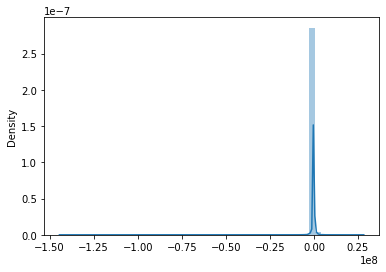

In [52]:
sns.distplot(data["prediction"] - data["proto_prediction_raw"])

In [53]:
(np.abs(data["prediction"] - data["proto_prediction_raw"]) / data["prediction"]).mean()

0.020450498046570113

In [54]:
(np.abs(data["prediction"] - data["target"]) / data["target"]).mean()

0.4197449141066495

In [55]:
(np.abs(data["proto_prediction_raw"] - data["target"]) / data["target"]).mean()

0.4144104233060329

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

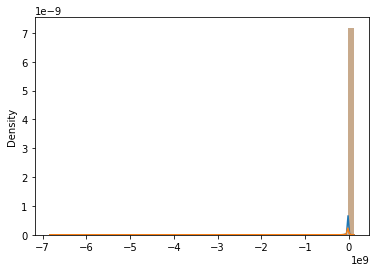

In [56]:
sns.distplot(data["prediction"] - data["target"])
sns.distplot(data["proto_prediction_raw"] - data["target"])

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

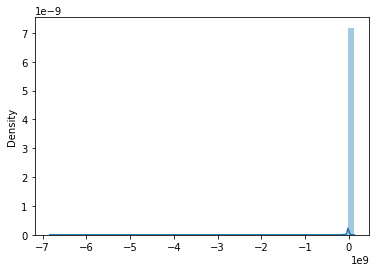

In [57]:
sns.distplot(data["proto_prediction_raw"] - data["target"])